# Previsão de preços de um Airbnb em Washington DC

Analisando um dataframe com as diversas características levadas em conta para o listing de uma propriedade para aluguel no site Airbnb, o projeto teve como intúito principal a utilização do machine learning para predizer o preço de uma propriedade qualquer na cidade de Washington com base nas características de cada propriedade.

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import os 
import csv
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

Como filtro inicial para decidir quais as características relevantes para previsão do preço, buscamos nos ater as características comumente expostas ao usuário no listing. Dessa forma, foi possível selecionar as características das propriedades do dataframe para servir de base de dados para o machine learning.

In [30]:
#Trazendo os dados para o python
data = pd.read_excel('listings.xlsx')
df = data.loc[(data.state=='DC')&(data.city=='Washington')]
dataframe = data.loc[(data.state=='DC')&(data.city=='Washington')]

As características selecionadas abaixo são: Latitude, Longitude, Tipo de propriedade, Número de: Banheiros, Quartos e Camas, Preço (para servir de base para o machine learning no processo de predição dos preços futuros), Preço por pessoa extra, Número mínimo de noites, Revisão dos clientes e Política de cancelamento.

In [31]:
#Selecionando somente as colunas que queremos trabalhar com e tirando os sinais de moedas 
colunas = ["latitude", "longitude", "property_type","bathrooms", "bedrooms", "beds", "price","extra_people","minimum_nights", "review_scores_rating","cancellation_policy"]
df = df.loc[:,colunas]

df.price = df.price.str.replace('$', '')
df.price = df.price.str.replace(',', '')
df.extra_people = df.extra_people.str.replace('$', '')


df['price']=df['price'].astype(float)
df['extra_people']= df['extra_people'].astype(float)
df = df.dropna()





Tomando como base as características selecionadas anteriomente, é evidente que foram agrupadas dados qualitativos e quantitativos. No entanto, para conseguir relacionar os dois, é necessário passar por alguns processos que serão descritos no decorrer do código. Assim, com uma formalização para uma mesma unidade de medida, é possivel relacionar características qualitativas com quantitativas para obter maior precisão na analise.

## Correlações 

Iniciamos a análise pelas variáveis qualitativas. Para tanto, produzimos um boxplot para melhor entender o comportamento de cada possível qualidade no preço. No caso, as características qualitativas foram: o tipo de propriedade e a política de cancelamento.

Os gráficos estão disponibilizados abaixo.

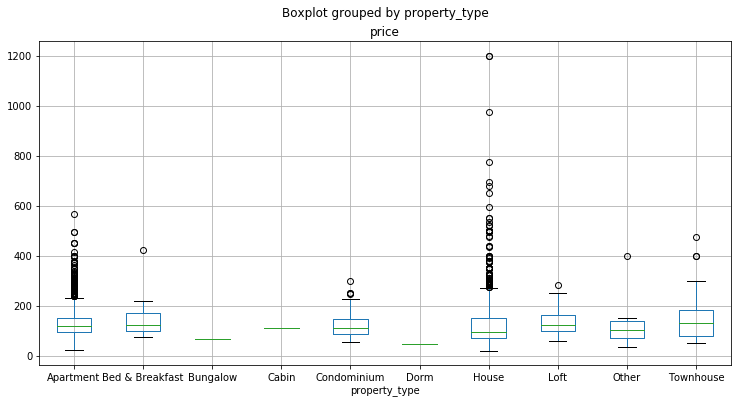

In [32]:
#Analisando a variavel quali Propery type e vendo se vale a pena adicionar ela ao nosso modelo

plt.rcParams['figure.figsize'] = (12,6)
df.boxplot(column=['price'], by='property_type');

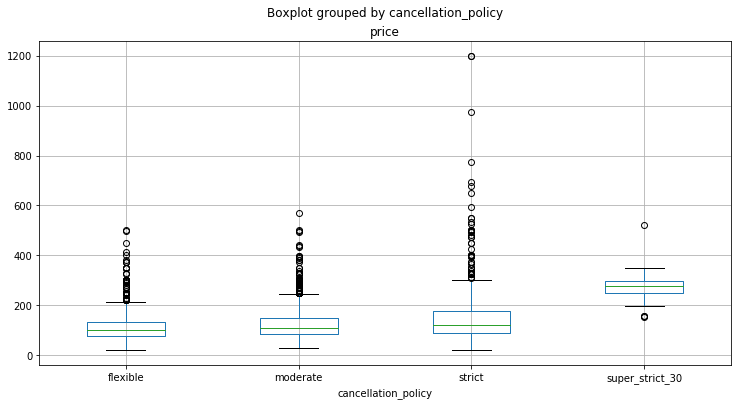

In [33]:
plt.rcParams['figure.figsize'] = (12,6)
df.boxplot(column=['price'], by='cancellation_policy');

O boxplot apresenta o comportamento do preço de acordo com a variável. São, portanto, apresentados os quadrantes dos dados, ou seja, a cada 25% da amostra coletada. Dessa forma, as linhas indicam os valores que contém o 0%, 25%, 50%, 75% e 100% de cada variável.


No entanto, com base nos boxplots plotados, é evidente um grande número de outliers, ou seja, valores muito discrepantes dos demais, logo, ultrapassam o desvio padrão. Isso ocorre, pois o boxplot possui um layout que é mais adequado para dados simétricos. Os outliers, portanto, representam valores fora do esperado, mas ainda assim, devem ser considerados para nossos dados.

Para a análise exploratória das variáveis quantitativas buscamos estabelecer o grau de correlação de cada uma delas não só com o preço mas entre umas as outras. Isso se faz necessário, pois as variáveis possuem,também, impacto entre si. Variáveis com correlação muito grande entre si devem também passar por adaptações visando a escolha de apenas uma, ou criação de uma nova, optimizando o resultado final.

Correlacao latitude vs price : -0.11977850029420414
Correlacao longitude vs price : -0.13265110792733373
Correlacao bathrooms vs price : 0.5263197092853233
Correlacao bedrooms vs price : 0.6104477984168931
Correlacao beds vs price : 0.566826558048037
Correlacao extra_people vs price : 0.1633593478911218
Correlacao minimum_nights vs price : 0.034239469945253315
Correlacao review_scores_rating vs price : 0.051161156394228885


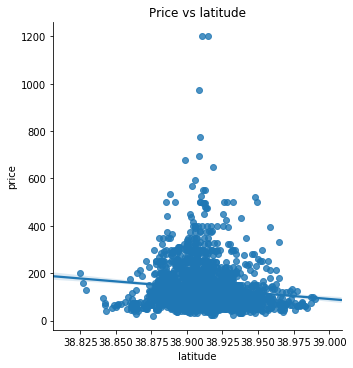

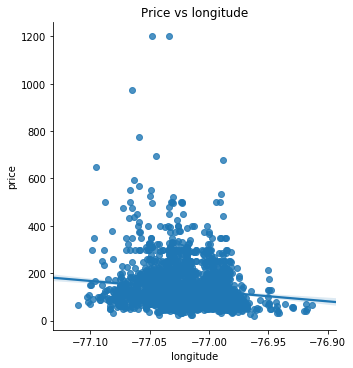

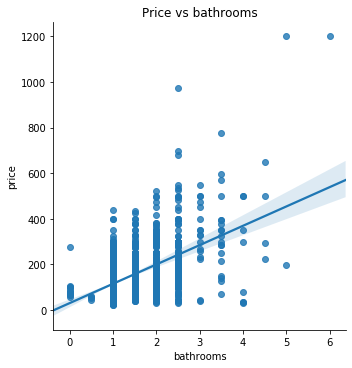

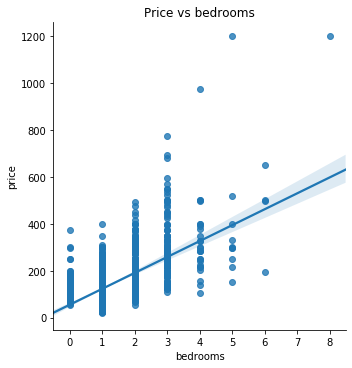

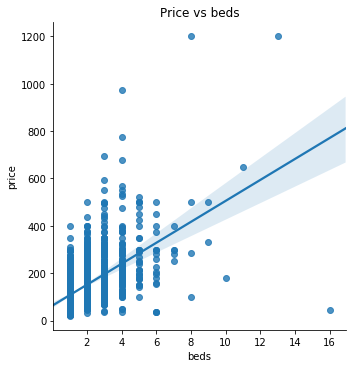

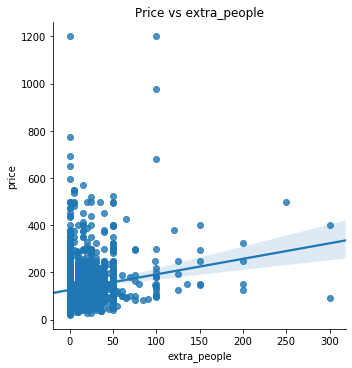

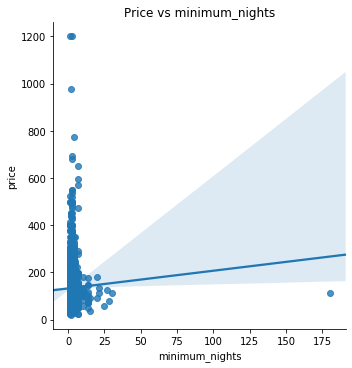

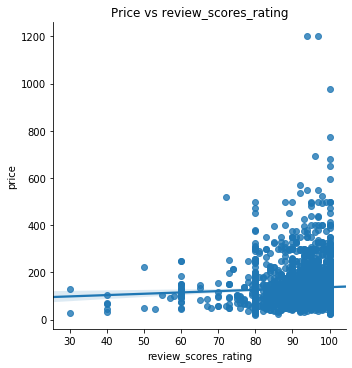

In [34]:
#criando uma funcao
colunas_quant= [ "latitude", "longitude","bathrooms", "bedrooms", "beds","extra_people","minimum_nights", "review_scores_rating"]

def funcao_corr(lista):
    for x in colunas_quant:
        sns.lmplot(x = x, y = 'price', data = df)
        plt.title('Price vs {0}'.format(x))
        print('Correlacao {0} vs price : {1}'.format(x,df.price.corr(df[x])))
        
        
funcao_corr(colunas_quant)
        
        

Os gráficos acima apresentam as variáveis quantitativas comparadas com o preço de cada imóvel. Para facilitar o entendimento dos gráficos foi plotado, também, a linha de tendência média das variáveis.


Além disso, a correlação de cada característica com o preço indica o quão relaciodos estão a varíavel com a alteração do preço. Quanto maior for a correlação, em módulo, maior é a influência da característica em questão com o preço. 

Outra maneira de analisar a influência de cada varíavel com o preço é o heatmap. De forma que a cor do quadado indica a correlação entre as variáveis. Cores frias representam pouca correlação e cores quentes representam alta correlação. É evidente que as variáveis relacionadas consigo mesmas, darão uma correlação ideal (quadrados brancos).

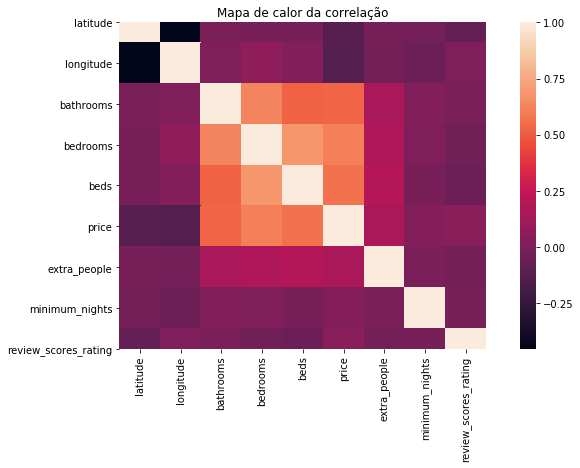

In [35]:
matrix = df.corr()
sns.heatmap(matrix, square = True);
plt.title('Mapa de calor da correlação');

In [36]:
#testando o metodo de regressao linear para prever o preco

A partir da análise dos gráficos individuais das variáveis quantitativas ficou claro que não seria ideal o método de regressão linear para a previsão em questão, visto que havia uma defasagem muito grande da linha de tendência na maioria dos gráficos.

Logo, com base na análise dos resultados obtidos, chegamos a conclusão de que o método do random forest regression seria uma melhor maneira de análisar os dados, como pode ser observado a seguir.

# Random Forest Regression

A partir dos resultados anteriormente observados optamos pelo uso do método de Random forest regression para análise dos dados, método o qual gera um determinado número de árvores de possibilidades com ordens aleatórias de aplicação dos atributos visando prever o valor com base nos precedentes fornecidos na base de treinamento com características similares.

## 1a regressão

A primeira iteração da regressão foi efetuada utilizando apenas as características qualitativas observadas.

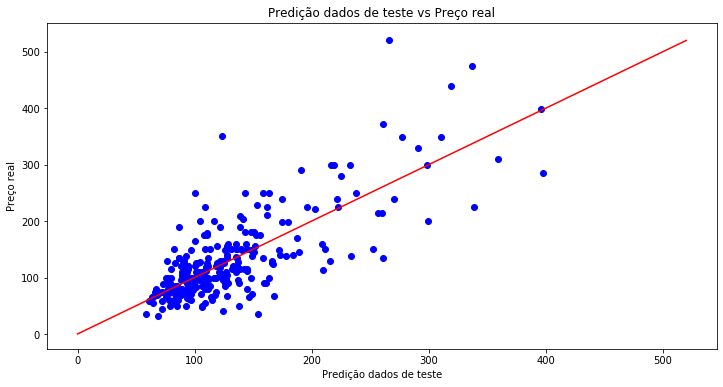

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

#Implementando o modelo de regressao random forest
variaveis = []

for x in colunas_quant:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df[colunas_quant], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 50)

regr.fit(X_train, y_train)

predicao1 = regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao1,y_test, c='b')
plt.title('Predição dados de teste vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de teste')
plt.show()

In [38]:

print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao1)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao1)))

O erro absoluto médio do df Teste é de: 33.6328 USD
O erro médio quadrático do df Teste é de: 0.11355450632156817 USD


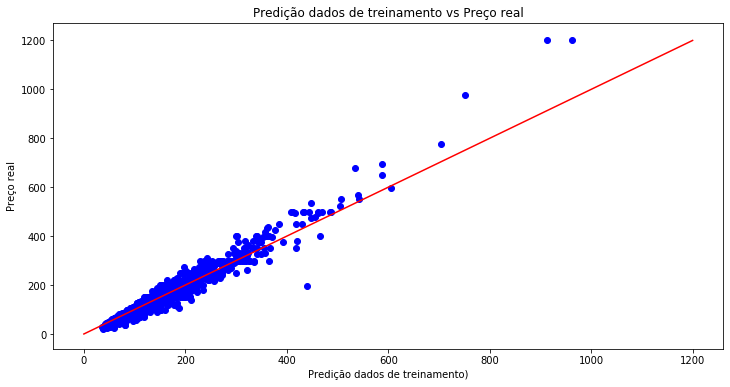

In [39]:
variaveis = []

for x in colunas_quant:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df[colunas_quant], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 50)

regr.fit(X_train, y_train)

predicao1 = regr.predict(X_train)

y1 = np.max(y_train)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao1,y_train, c='b')
plt.title('Predição dados de treinamento vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de treinamento)')
plt.show()

In [40]:
print('O erro absoluto médio do df Treinamento é de: {0} USD'.format(mean_absolute_error(y_train,predicao1)))
print('O erro médio quadrático do df Treinamento é de: {0} USD'.format(mean_squared_log_error(y_train,predicao1)))

O erro absoluto médio do df Treinamento é de: 12.645426262626263 USD
O erro médio quadrático do df Treinamento é de: 0.018526584260592303 USD


## 2a regressão -*óptima*

A segunda regressão consistiu na conversão dos atributos qualitativos a serem analisados em "quantitativos" por meio da criação de Dummies para que estes valores possam ser compreendidos pelo Random Forest Regressor.

In [41]:
colunas_t = []

dummies = df['property_type'].str.get_dummies(" ")
dummies2 = df['cancellation_policy'].str.get_dummies(" ")
df2 = pd.concat([df, dummies], axis=1, sort=False)
df3 = pd.concat([df2, dummies2], axis=1, sort=False)

for y in df3.columns:
    if y!= '&' and y!='property_type'and y!='cancellation_policy'and y!='price':
        colunas_t.append(y)
        
colunas_t

['latitude',
 'longitude',
 'bathrooms',
 'bedrooms',
 'beds',
 'extra_people',
 'minimum_nights',
 'review_scores_rating',
 'Apartment',
 'Bed',
 'Breakfast',
 'Bungalow',
 'Cabin',
 'Condominium',
 'Dorm',
 'House',
 'Loft',
 'Other',
 'Townhouse',
 'flexible',
 'moderate',
 'strict',
 'super_strict_30']

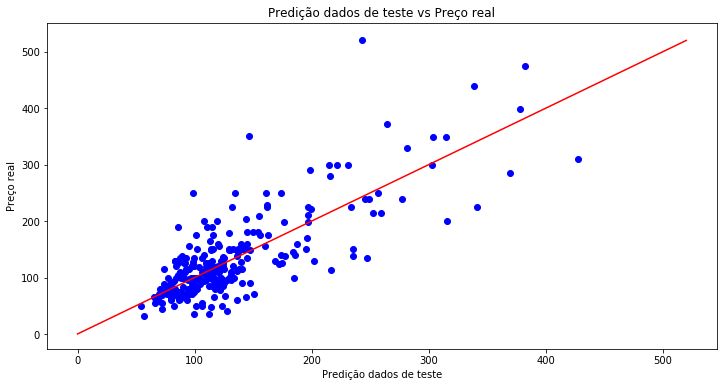

In [42]:

variaveis = []

for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunas_t], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao2= regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao2,y_test, c='b')
plt.title('Predição dados de teste vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de teste')
plt.show()

In [43]:
print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao2)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao2)))

O erro absoluto médio do df Teste é de: 31.78818181818182 USD
O erro médio quadrático do df Teste é de: 0.10258869125202792 USD


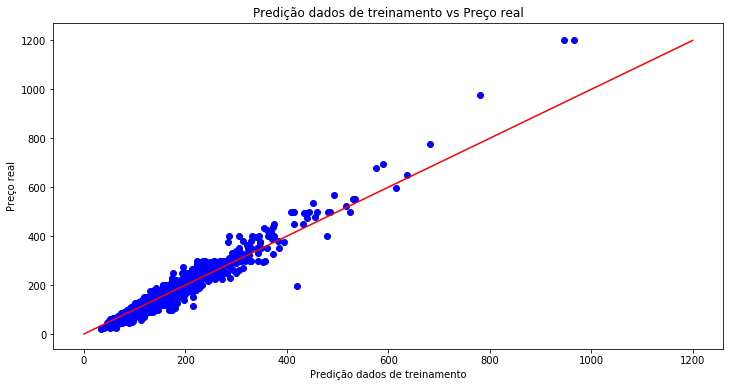

In [44]:
variaveis = []

for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunas_t], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao2= regr.predict(X_train)

y1 = np.max(y_train)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao2,y_train, c='b')
plt.title('Predição dados de treinamento vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de treinamento')
plt.show()

In [45]:
print('O erro absoluto médio do df Treinamento é de: {0} USD'.format(mean_absolute_error(y_train,predicao2)))
print('O erro médio quadrático do df Treinamento é de: {0} USD'.format(mean_squared_log_error(y_train,predicao2)))

O erro absoluto médio do df Treinamento é de: 12.249458585858587 USD
O erro médio quadrático do df Treinamento é de: 0.01795042886147241 USD


## 3a regressão

Com o intuito de optimizar o resultado obtido, buscamos a remoção de atributos que não apresentassem grande relevância para o resultado assim a retirada dos mesmos seria benéfica. 

Apesar de tentarmos a remoção de variáveis, buscando maior precisão do preditor uma vez que feita a primeira remoção, esta sendo a da característica 'review_scores_rating', não houveram resultados positivos ao efetuar a retirada de uma segunda, assim podendo-se dizer que chegamos à precisão máxima para tais características (com a retirada da característica de menor relevância após a retirada da primeira, foi observado um decréscimo na precisão da previsão).
    

In [46]:
colunasj=[]
for x in colunas_t:
    if x!='review_scores_rating':
        colunasj.append(x)

ValueError: x and y must be the same size

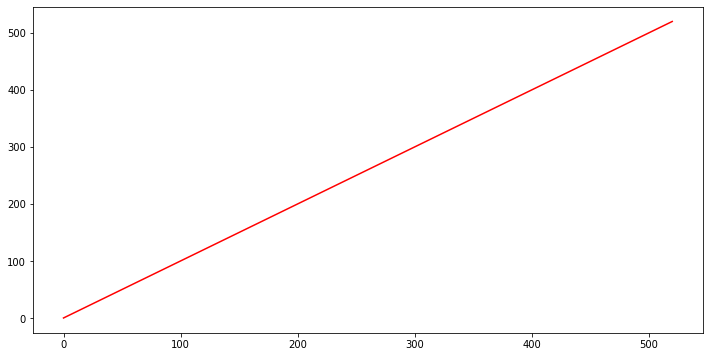

In [47]:

variaveis = []


for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunasj], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao3= regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')


plt.scatter(predicao2,y_test, c='b')
plt.title('Predição dados de teste vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de teste')
plt.show()

In [ ]:
print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao3)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao3)))

In [ ]:
variaveis = []


for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunasj], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao3= regr.predict(X_train)

y1 = np.max(y_train)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')


plt.scatter(predicao2,y_train, c='b')
plt.title('Predição dados de treinamento vs Preço real')
plt.ylabel('Preço real')
plt.xlabel('Predição dados de treinamento')
plt.show()

In [ ]:
print('O erro absoluto médio do df Treinamento é de: {0} USD'.format(mean_absolute_error(y_train,predicao1)))
print('O erro médio quadrático do df Treinamento é de: {0} USD'.format(mean_squared_log_error(y_train,predicao1)))

## Conclusão

O preditor teve sucesso considerável em sua última iteração, com uma taxa de erro média por volta de 31 USD , o último ajuste referente à remoção de uma característica irrelevante não foi significativo para o caso em questão, visto que as características selecionadas em maioria apresentam uma grande contribuição à precisão final, apesar da remoção da característica efetuada não ter representado grandes mudanças no resultado final.